<a href="https://colab.research.google.com/github/yayanhidayaat/klasifikasi/blob/main/SKRRRPPPP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import zipfile
import shutil
from pathlib import Path
import pickle
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# 🔹 Path dataset di Google Drive dan lokal
GDRIVE_DATASET_PATH = "/content/drive/Shareddrives/STORE ASYFA/Yayan/riceleafs"
LOCAL_DATASET_PATH = "/content/riceleafs"
ZIP_FILE_PATH = "/content/riceleafs.zip"
RUNTIME_FILE = "/content/drive/Shareddrives/STORE ASYFA/Yayan/runtime.pkl"
KAGGLE_JSON_PATH = "/content/drive/Shareddrives/STORE ASYFA/Yayan/kaggle.json"

def check_and_copy_dataset():
    if os.path.exists(GDRIVE_DATASET_PATH) and len(os.listdir(GDRIVE_DATASET_PATH)) > 0:
        print("✅ Dataset ditemukan di Google Drive! Menyalin ke lokal...")
        if os.path.exists(LOCAL_DATASET_PATH):
            shutil.rmtree(LOCAL_DATASET_PATH)
        shutil.copytree(GDRIVE_DATASET_PATH, LOCAL_DATASET_PATH)
    else:
        download_dataset_from_kaggle()

def download_dataset_from_kaggle():
    print("⚠️ Dataset belum ada di Google Drive. Mengunduh dari Kaggle...")
    !pip install -q kaggle
    kaggle_config_dir = "/root/.kaggle"
    os.makedirs(kaggle_config_dir, exist_ok=True)
    if os.path.exists(KAGGLE_JSON_PATH):
        shutil.copy(KAGGLE_JSON_PATH, os.path.join(kaggle_config_dir, "kaggle.json"))
        os.chmod(os.path.join(kaggle_config_dir, "kaggle.json"), 0o600)
    else:
        raise FileNotFoundError("❌ kaggle.json tidak ditemukan di Google Drive!")
    if not os.path.exists(ZIP_FILE_PATH):
        print("🔽 Mengunduh dataset dari Kaggle...")
        os.system(f"kaggle datasets download -d shayanriyaz/riceleafs -p /content")
    extract_and_save_dataset()

def extract_and_save_dataset():
    if not os.path.exists(ZIP_FILE_PATH):
        raise FileNotFoundError(f"❌ Gagal mengunduh dataset. File {ZIP_FILE_PATH} tidak ditemukan!")
    print("📂 Mengekstrak dataset...")
    os.makedirs(LOCAL_DATASET_PATH, exist_ok=True)
    with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
        zip_ref.extractall(LOCAL_DATASET_PATH)
    print("💾 Menyimpan dataset ke Google Drive...")
    os.makedirs(GDRIVE_DATASET_PATH, exist_ok=True)
    shutil.copytree(LOCAL_DATASET_PATH, GDRIVE_DATASET_PATH, dirs_exist_ok=True)

def select_correct_dataset_folder():
    folder_option1 = os.path.join(LOCAL_DATASET_PATH, "RiceLeafs")
    folder_option2 = os.path.join(LOCAL_DATASET_PATH, "riceleafs")
    if os.path.exists(folder_option1):
        return folder_option1
    elif os.path.exists(folder_option2):
        return folder_option2
    else:
        raise FileNotFoundError(f"❌ Tidak ditemukan folder 'RiceLeafs' atau 'riceleafs' di dalam {LOCAL_DATASET_PATH}")

def save_runtime_data():
    runtime_data = {"dataset_downloaded": True, "download_path": LOCAL_DATASET_PATH}
    with open(RUNTIME_FILE, "wb") as f:
        pickle.dump(runtime_data, f)

check_and_copy_dataset()
dataset_path = select_correct_dataset_folder()
save_runtime_data()

print(f"\n✅ Dataset siap digunakan! Folder yang dipilih: {dataset_path}")
print("📂 Isi folder dataset:", os.listdir(dataset_path))


Mounted at /content/drive
✅ Dataset ditemukan di Google Drive! Menyalin ke lokal...

✅ Dataset siap digunakan! Folder yang dipilih: /content/riceleafs/RiceLeafs
📂 Isi folder dataset: ['train', 'validation']


In [4]:
import os
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from openpyxl import load_workbook

# 🔹 Gunakan path dataset yang sudah dipilih
DATASET_PATH = dataset_path  # Pastikan variabel ini dari kode sebelumnya

# 🔹 Cek apakah dataset tersedia
if not os.path.exists(DATASET_PATH) or not os.listdir(DATASET_PATH):
    raise FileNotFoundError(f"❌ Dataset tidak ditemukan di {DATASET_PATH}")

# 🔹 Kelas dalam dataset
CLASSES = ["BrownSpot", "Healthy", "Hispa", "LeafBlast"]

# 🔹 Menentukan direktori penyimpanan setelah preprocessing
PROCESSED_DATASET_NAME = "/content/drive/Shareddrives/STORE ASYFA/Yayan/riceleafs/Rice_Leafs_Dataset_Aug_Preprocessed_224x224"
SAVE_PATHS = {cls: os.path.join(PROCESSED_DATASET_NAME, cls) for cls in CLASSES}

# 🔹 Buat direktori penyimpanan jika belum ada
os.makedirs(PROCESSED_DATASET_NAME, exist_ok=True)
for cls in CLASSES:
    os.makedirs(SAVE_PATHS[cls], exist_ok=True)

print("✅ Path dataset dan penyimpanan preprocessing telah disiapkan!")


✅ Path dataset dan penyimpanan preprocessing telah disiapkan!


In [5]:
import os

# 🔹 Isi file environment_setup.py
environment_setup_code = f"""# environment_setup.py

import os

# Path ke dataset
DATASET_PATH = "/content/drive/Shareddrives/STORE ASYFA/Yayan/riceleafs/RiceLeafs"

# Kelas dalam dataset (ubah sesuai dengan dataset Anda)
CLASSES = ["Healthy", "Hispa", "BrownSpot", "LeafBlast"]

# Path penyimpanan setelah pemrosesan
PROCESSED_DATASET_NAME = "/content/drive/Shareddrives/STORE ASYFA/Yayan/riceleafs/Rice_Leafs_Dataset_Aug_Preprocessed_224x224"
SAVE_PATHS = {{cls: os.path.join(PROCESSED_DATASET_NAME, cls) for cls in CLASSES}}
"""

# 🔹 Membuat file environment_setup.py
with open("environment_setup.py", "w") as f:
    f.write(environment_setup_code)

print("✅ File environment_setup.py berhasil dibuat!")


✅ File environment_setup.py berhasil dibuat!


In [6]:
import os
import numpy as np
from pathlib import Path
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 🔹 Impor konfigurasi dari environment_setup.py
from environment_setup import DATASET_PATH, CLASSES

# 🔹 Tentukan path penyimpanan hasil augmentasi
SAVE_PROCESSED_PATH = "/content/processed_images"
os.makedirs(SAVE_PROCESSED_PATH, exist_ok=True)
SAVE_PATHS = {cls: os.path.join(SAVE_PROCESSED_PATH, cls) for cls in CLASSES}
for path in SAVE_PATHS.values():
    os.makedirs(os.path.join(path, "images"), exist_ok=True)

# 🔹 Mengecek apakah dataset tersedia dan tidak kosong
if not os.path.exists(DATASET_PATH) or not os.listdir(DATASET_PATH):
    raise FileNotFoundError(f"❌ Folder dataset '{DATASET_PATH}' tidak ditemukan atau kosong!")

# 🔹 Mengumpulkan file gambar berdasarkan kelas
class_filespath = {cls: [] for cls in CLASSES}
for root, _, files in os.walk(DATASET_PATH):
    class_name = Path(root).name
    if class_name in class_filespath:
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Hanya gambar
                img_path = os.path.join(root, file)
                class_filespath[class_name].append(img_path)

# 🔹 Hitung jumlah gambar sebelum augmentasi
original_counts = {cls: len(files) for cls, files in class_filespath.items()}
print(f"📊 Jumlah gambar sebelum augmentasi: {original_counts}")

# 🔹 Fungsi untuk mengubah gambar menjadi array dengan ukuran 224x224
def images_to_array(filespath, img_size=224):
    images_arr = []
    for filepath in tqdm(filespath, desc="📸 Processing Images"):
        image = load_img(filepath, color_mode="rgb", target_size=(img_size, img_size))
        image = img_to_array(image) / 255.0  # Normalisasi (0-1)
        images_arr.append(image)
    return np.array(images_arr, dtype=np.float32)

# 🔹 Mengonversi dataset ke dalam array
arrays_to_save = {cls: images_to_array(class_filespath[cls]) for cls in CLASSES if class_filespath[cls]}

# 🔹 Menyimpan gambar yang telah diproses
for cls, images in arrays_to_save.items():
    save_path_images = os.path.join(SAVE_PATHS[cls], "images")
    os.makedirs(save_path_images, exist_ok=True)  # Pastikan direktori ada

    for idx, image_arr in enumerate(tqdm(images, desc=f"💾 Saving {cls} images"), 1):
        save_img(os.path.join(save_path_images, f"{cls}_{idx}.jpg"), image_arr)

# 🔹 Augmentasi & Oversampling Data
if arrays_to_save:
    max_class = max(arrays_to_save, key=lambda cls: len(arrays_to_save[cls]))
    max_count = len(arrays_to_save[max_class])  # Jumlah gambar kelas terbesar

    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    for cls, images in arrays_to_save.items():
        save_path_images = os.path.join(SAVE_PATHS[cls], "images")
        os.makedirs(save_path_images, exist_ok=True)

        image_count = len(images)

        # 🔹 Augmentasi hanya jika jumlah gambar kurang dari kelas terbesar
        if image_count < max_count:
            oversample_count = max_count - image_count
            print(f"🔄 Augmenting '{cls}' ({image_count} ➝ {max_count})")

            aug_images = []
            aug_generator = datagen.flow(images, batch_size=1)
            for _ in tqdm(range(oversample_count), desc=f"🔄 Generating augmented {cls} images"):
                batch = next(aug_generator)
                aug_images.append(batch[0])

            # Simpan hasil augmentasi
            for idx, image_arr in enumerate(aug_images, 1):
                save_img(os.path.join(save_path_images, f"{cls}_aug_{idx}.jpg"), image_arr)

            print(f"✅ {cls} selesai diaugmentasi ({image_count + len(aug_images)})")

# 🔹 Validasi jumlah gambar setelah augmentasi
final_counts = {cls: len(os.listdir(os.path.join(SAVE_PATHS[cls], "images"))) for cls in CLASSES}
print(f"\n📊 Jumlah gambar setelah augmentasi: {final_counts}")


📊 Jumlah gambar sebelum augmentasi: {'Healthy': 1488, 'Hispa': 565, 'BrownSpot': 523, 'LeafBlast': 779}


💾 Saving LeafBlast images: 100%|██████████| 779/779 [00:01<00:00, 558.16it/s]


🔄 Augmenting 'Hispa' (565 ➝ 1488)


🔄 Generating augmented Hispa images: 100%|██████████| 923/923 [00:25<00:00, 36.70it/s]


✅ Hispa selesai diaugmentasi (1488)
🔄 Augmenting 'BrownSpot' (523 ➝ 1488)


🔄 Generating augmented BrownSpot images: 100%|██████████| 965/965 [00:19<00:00, 48.37it/s]


✅ BrownSpot selesai diaugmentasi (1488)
🔄 Augmenting 'LeafBlast' (779 ➝ 1488)


🔄 Generating augmented LeafBlast images: 100%|██████████| 709/709 [00:15<00:00, 45.98it/s]


✅ LeafBlast selesai diaugmentasi (1488)

📊 Jumlah gambar setelah augmentasi: {'Healthy': 1488, 'Hispa': 1488, 'BrownSpot': 1488, 'LeafBlast': 1488}


<ipython-input-7-47ca1be39eb8>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(CLASSES, rotation=30)
<ipython-input-7-47ca1be39eb8>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(CLASSES, rotation=30)


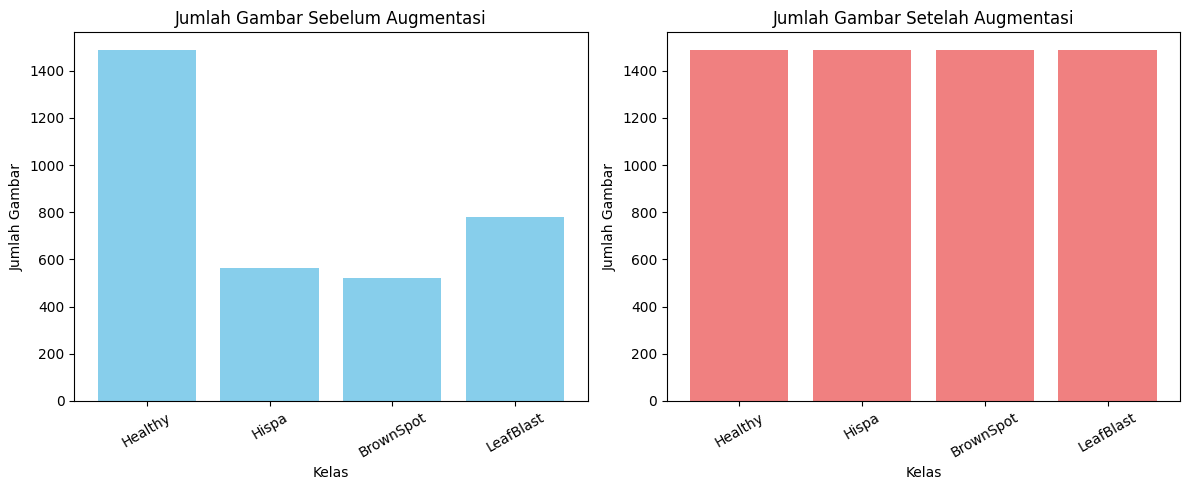

In [7]:
import os
import matplotlib.pyplot as plt
from environment_setup import CLASSES, SAVE_PATHS

# 🔹 Hitung jumlah gambar setelah augmentasi
augmented_counts = {cls: len(os.listdir(os.path.join(SAVE_PATHS[cls], "images"))) for cls in CLASSES}

# 🔹 Menampilkan grafik sebelum & sesudah augmentasi
def plot_data_distribution(original_counts, augmented_counts):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # 🔹 Grafik sebelum augmentasi
    axes[0].bar(original_counts.keys(), original_counts.values(), color='skyblue')
    axes[0].set_title("Jumlah Gambar Sebelum Augmentasi")
    axes[0].set_xlabel("Kelas")
    axes[0].set_ylabel("Jumlah Gambar")
    axes[0].set_xticklabels(CLASSES, rotation=30)

    # 🔹 Grafik setelah augmentasi
    axes[1].bar(augmented_counts.keys(), augmented_counts.values(), color='lightcoral')
    axes[1].set_title("Jumlah Gambar Setelah Augmentasi")
    axes[1].set_xlabel("Kelas")
    axes[1].set_ylabel("Jumlah Gambar")
    axes[1].set_xticklabels(CLASSES, rotation=30)

    plt.tight_layout()
    plt.show()

# 🔹 Panggil fungsi plotting
plot_data_distribution(original_counts, augmented_counts)


In [8]:
  import os
  import pandas as pd
  from sklearn.preprocessing import OneHotEncoder
  from sklearn.utils import shuffle
  from tqdm import tqdm
  from environment_setup import DATASET_PATH, CLASSES  # Impor variabel lingkungan

  # 🔹 Path ke folder Train & Validation
  TRAIN_PATH = os.path.join(DATASET_PATH, "train")
  VAL_PATH = os.path.join(DATASET_PATH, "validation")

  # 🔹 Periksa apakah folder ada
  if not os.path.exists(TRAIN_PATH) or not os.path.exists(VAL_PATH):
      raise FileNotFoundError("❌ Folder train atau validation tidak ditemukan! Pastikan dataset sudah diproses.")

  # 🔹 Menyimpan path gambar dan label
  train_images_path, val_images_path = [], []
  train_labels, val_labels = [], []

  # 🔹 Fungsi untuk mengumpulkan gambar dari folder
  def collect_images(folder_path, label_storage, image_storage):
      for label in CLASSES:
          label_path = os.path.join(folder_path, label)

          if not os.path.exists(label_path):
              print(f"⚠️ Folder tidak ditemukan: {label_path}")
              continue

          image_files = [
              os.path.join(label_path, f)
              for f in os.listdir(label_path)
              if f.lower().endswith(('.png', '.jpg', '.jpeg'))
          ]

          if len(image_files) == 0:
              print(f"⚠️ Tidak ada gambar di kelas '{label}', dilewati.")
              continue

          image_storage.extend(image_files)
          label_storage.extend([label] * len(image_files))

  # 🔹 Mengumpulkan data train dan validation
  collect_images(TRAIN_PATH, train_labels, train_images_path)
  collect_images(VAL_PATH, val_labels, val_images_path)

  # 🔹 Konversi ke DataFrame (Opsional, untuk debugging)
  train_df = pd.DataFrame({"image_path": train_images_path, "label": train_labels})
  val_df = pd.DataFrame({"image_path": val_images_path, "label": val_labels})

  # 🔹 One-Hot Encoding untuk label
  one_hot_enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
  train_labels_onehot = one_hot_enc.fit_transform(pd.DataFrame(train_labels))
  val_labels_onehot = one_hot_enc.transform(pd.DataFrame(val_labels))

  # 🔹 Mengacak data train untuk menghindari bias
  train_images_path, train_labels, train_labels_onehot = shuffle(
      train_images_path, train_labels, train_labels_onehot, random_state=42
  )

  # 🔹 Print hasil pemrosesan
  print("\n✅ Dataset berhasil diproses!")
  print(f"🔹 Jumlah gambar Train     : {len(train_images_path)}")
  print(f"🔹 Jumlah gambar Validation: {len(val_images_path)}")


✅ Dataset berhasil diproses!
🔹 Jumlah gambar Train     : 2684
🔹 Jumlah gambar Validation: 671


In [9]:
pip install xlsxwriter

In [10]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from environment_setup import CLASSES  # Ambil daftar kelas

# 🔹 Pastikan variabel train_images_path, train_labels, train_labels_onehot sudah ada dari pemrosesan sebelumnya!

# 🔹 Menentukan parameter
N_SPLITS = 5
OUTPUT_FILE = "dataset_splits.xlsx"

# 🔹 Pastikan train_labels_onehot dalam format NumPy array
train_labels_onehot = np.array(train_labels_onehot)

# 🔹 K-Fold Split
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

with pd.ExcelWriter(OUTPUT_FILE, engine="xlsxwriter") as writer_excel:
    for i, (train_idx, val_idx) in enumerate(kf.split(train_images_path), start=1):
        fold_train_images = [train_images_path[idx] for idx in train_idx]
        fold_val_images = [train_images_path[idx] for idx in val_idx]

        fold_train_labels = [train_labels[idx] for idx in train_idx]
        fold_val_labels = [train_labels[idx] for idx in val_idx]

        fold_train_labels_onehot = train_labels_onehot[train_idx, :]
        fold_val_labels_onehot = train_labels_onehot[val_idx, :]

        # 🔹 Fungsi untuk membuat DataFrame
        def create_dataframe(image_paths, labels, one_hot_labels):
            df = pd.DataFrame({"image_path": image_paths, "label": labels})
            for j, class_name in enumerate(CLASSES):
                df[class_name] = one_hot_labels[:, j]  # ✅ Perbaikan indexing
            return df

        train_df = create_dataframe(fold_train_images, fold_train_labels, fold_train_labels_onehot)
        val_df = create_dataframe(fold_val_images, fold_val_labels, fold_val_labels_onehot)

        # 🔹 Menyimpan ke Excel
        train_df.to_excel(writer_excel, sheet_name=f"Fold_{i}_Train", index=False)
        val_df.to_excel(writer_excel, sheet_name=f"Fold_{i}_Val", index=False)

print(f"✅ Data split telah disimpan di {OUTPUT_FILE}")


✅ Data split telah disimpan di dataset_splits.xlsx


In [11]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 🔹 Konstanta
EXCEL_FILENAME = "dataset_splits.xlsx"  # Nama file Excel yang digunakan
IMG_SIZE = 224  # Ukuran gambar yang diinginkan
LABEL_COLUMNS = ['Healthy', 'Hispa', 'BrownSpot', 'LeafBlast']  # Nama label yang benar

def getArrFromExcel(sheet_name):
    """
    Membaca dataset dari file Excel dan mengonversinya menjadi array gambar dan label.

    Parameters:
        sheet_name (str): Nama sheet dalam file Excel yang akan dibaca.

    Returns:
        tuple: (numpy.ndarray dari gambar, numpy.ndarray dari label)
    """
    try:
        # 🔹 Membaca file Excel dengan engine openpyxl (jika belum terinstal, gunakan xlsxwriter)
        df = pd.read_excel(EXCEL_FILENAME, sheet_name=sheet_name, engine="openpyxl")
        print(f"✅ Sheet '{sheet_name}' berhasil dibaca.")

        # 🔹 Periksa apakah 'image_path' ada dalam dataset
        if "image_path" not in df.columns:
            print("❌ Kolom 'image_path' tidak ditemukan dalam file Excel! Periksa kembali format dataset.")
            return None, None

        # 🔹 Menampilkan kolom yang tersedia
        print(f"📊 Kolom yang ditemukan di dataset: {list(df.columns)}")

        # 🔹 Periksa apakah semua kolom label one-hot ada
        missing_labels = [col for col in LABEL_COLUMNS if col not in df.columns]
        if missing_labels:
            print(f"⚠️ Kolom label one-hot tidak ditemukan: {missing_labels}. Periksa kembali file Excel!")
            return None, None

        # 🔹 Mengambil path gambar dan label one-hot
        images_path = df["image_path"].values
        labels = df[LABEL_COLUMNS].values  # Menggunakan label yang benar

        # 🔹 Menyimpan array gambar
        images_arr = []

        for image_path in tqdm(images_path, desc="📸 Loading Images"):
            try:
                img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
                images_arr.append(img_to_array(img))
            except Exception as e:
                print(f"⚠️ Error loading image {image_path}: {e}")
                continue  # Lewati gambar yang gagal dimuat

        # 🔹 Konversi ke NumPy array
        images_arr = np.array(images_arr, dtype="float32")
        labels = np.array(labels, dtype="float32")

        print(f"✅ Dataset dari '{sheet_name}' berhasil dikonversi!")
        return images_arr, labels

    except Exception as e:
        print(f"❌ Error membaca file Excel: {e}")
        return None, None

# 🔹 Contoh penggunaan
images, labels = getArrFromExcel("Fold_1_Train")

if images is not None and labels is not None:
    print(f"✅ Dataset berhasil dimuat: Gambar {images.shape}, Label {labels.shape}")
else:
    print("⚠️ Terjadi kesalahan saat memuat dataset.")


✅ Sheet 'Fold_1_Train' berhasil dibaca.
📊 Kolom yang ditemukan di dataset: ['image_path', 'label', 'Healthy', 'Hispa', 'BrownSpot', 'LeafBlast']


📸 Loading Images: 100%|██████████| 2147/2147 [04:07<00:00,  8.69it/s]


✅ Dataset dari 'Fold_1_Train' berhasil dikonversi!
✅ Dataset berhasil dimuat: Gambar (2147, 224, 224, 3), Label (2147, 4)


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, applications

# 🔹 Konstanta
IMG_SIZE = 224
NUM_CLASSES = 4

def build_scratch_model():
    """Model tanpa transfer learning (train from scratch)"""
    base_model = applications.MobileNetV2(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights=None)
    base_model.trainable = True
    return tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation="relu"),
        layers.Dense(NUM_CLASSES, activation="softmax")
    ])

def build_fixed_feature_extraction_model():
    """Transfer Learning - Fixed Feature Extraction"""
    base_model = applications.MobileNetV2(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights="imagenet")
    base_model.trainable = False  # Freeze seluruh model
    return tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation="relu"),
        layers.Dense(NUM_CLASSES, activation="softmax")
    ])

def build_finetune_first_layer():
    """Transfer Learning - Fine-Tuning First Trainable Layer"""
    base_model = applications.MobileNetV2(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights="imagenet")
    base_model.trainable = False

    # 🔹 Unfreeze layer pertama yang bisa dilatih (skip layer input)
    first_trainable_layer = next((layer for layer in base_model.layers if "conv" in layer.name), None)
    if first_trainable_layer:
        first_trainable_layer.trainable = True

    return tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation="relu"),
        layers.Dense(NUM_CLASSES, activation="softmax")
    ])

def build_finetune_middle_layer():
    """Transfer Learning - Fine-Tuning Middle Layer"""
    base_model = applications.MobileNetV2(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights="imagenet")
    base_model.trainable = False
    total_layers = len(base_model.layers)

    middle_layer_index = total_layers // 2  # Indeks tengah
    fine_tune_range = 5  # Bisa diubah sesuai kebutuhan

    # 🔹 Pastikan indeks tidak keluar batas
    start_idx = max(0, middle_layer_index - fine_tune_range)
    end_idx = min(total_layers, middle_layer_index + fine_tune_range)

    for layer in base_model.layers[start_idx:end_idx]:
        layer.trainable = True

    return tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation="relu"),
        layers.Dense(NUM_CLASSES, activation="softmax")
    ])

def build_finetune_last_layer(ft_layers=25):
    """Transfer Learning - Fine-Tuning Last Layer"""
    base_model = applications.MobileNetV2(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights="imagenet")
    base_model.trainable = False

    # 🔹 Pastikan tidak melebihi jumlah layer
    ft_layers = min(ft_layers, len(base_model.layers))

    for layer in base_model.layers[-ft_layers:]:
        layer.trainable = True

    return tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation="relu"),
        layers.Dense(NUM_CLASSES, activation="softmax")
    ])

# 🔹 Inisialisasi model
models = {
    "Scratch": build_scratch_model(),
    "Fixed_Feature": build_fixed_feature_extraction_model(),
    "Fine_Tune_First": build_finetune_first_layer(),
    "Fine_Tune_Middle": build_finetune_middle_layer(),
    "Fine_Tune_Last": build_finetune_last_layer()
}

# 🔹 Kompilasi model
for name, model in models.items():
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    print(f"✅ Model '{name}' siap untuk dilatih!")


✅ Model 'Scratch' siap untuk dilatih!
✅ Model 'Fixed_Feature' siap untuk dilatih!
✅ Model 'Fine_Tune_First' siap untuk dilatih!
✅ Model 'Fine_Tune_Middle' siap untuk dilatih!
✅ Model 'Fine_Tune_Last' siap untuk dilatih!


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import pandas as pd
from tqdm import tqdm
import gc
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# 🔹 Konstanta
EXCEL_FILENAME = "dataset_splits.xlsx"
IMG_SIZE = 224
LABEL_COLUMNS = ['Healthy', 'Hispa', 'BrownSpot', 'LeafBlast']
BATCH_SIZE = 16  # Kurangi batch untuk hemat RAM
EPOCHS = 20
MODEL_SAVE_DIR = "saved_models"
N_SPLITS = 5

# 🔹 Fungsi untuk membaca dataset dari Excel (gunakan generator agar tidak membebani RAM)
def load_image_data(sheet_name):
    try:
        df = pd.read_excel(EXCEL_FILENAME, sheet_name=sheet_name)
        print(f"✅ Sheet '{sheet_name}' berhasil dibaca.")

        if not all(col in df.columns for col in LABEL_COLUMNS):
            print(f"⚠️ Kolom label one-hot tidak ditemukan dalam file Excel.")
            return None, None

        images_path = df["image_path"].values
        labels = df[LABEL_COLUMNS].values

        def image_generator():
            for image_path in images_path:
                try:
                    img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
                    yield img_to_array(img) / 255.0  # Normalisasi di sini
                except Exception as e:
                    print(f"❌ Error loading image {image_path}: {e}")
                    yield np.zeros((IMG_SIZE, IMG_SIZE, 3))  # Gambar dummy jika gagal

        return np.array(list(image_generator()), dtype="float32"), np.array(labels, dtype="float32")

    except Exception as e:
        print(f"❌ Error membaca file Excel: {e}")
        return None, None

# 🔹 Model yang akan digunakan
models = {
    "Scratch": build_scratch_model(),
    "Fixed_Feature": build_fixed_feature_extraction_model(),
    "Fine_Tune_First": build_finetune_first_layer(),
    "Fine_Tune_Middle": build_finetune_middle_layer(),
    "Fine_Tune_Last": build_finetune_last_layer()
}

# 🔹 Simpan hasil cross-validation
cv_results = {name: [] for name in models.keys()}

# 🔹 Looping 5-Fold Cross Validation
for fold in range(1, N_SPLITS + 1):
    print(f"\n🔄 Processing Fold {fold}/{N_SPLITS}")

    # Load dataset dengan generator
    train_images, train_labels = load_image_data(f"Fold_{fold}_Train")
    val_images, val_labels = load_image_data(f"Fold_{fold}_Val")

    if train_images is None or val_images is None:
        print(f"❌ Data Fold {fold} tidak bisa dimuat. Lewati fold ini.")
        continue

    # Gunakan ImageDataGenerator agar tidak menyimpan semua data di RAM
    train_datagen = ImageDataGenerator()
    val_datagen = ImageDataGenerator()

    train_generator = train_datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE)
    val_generator = val_datagen.flow(val_images, val_labels, batch_size=BATCH_SIZE)

    # Hapus dataset dari RAM setelah membuat generator
    del train_images, train_labels, val_images, val_labels
    gc.collect()

    # Train semua model di fold ini
    for model_name, model in models.items():
        print(f"\n🚀 Training Model: {model_name} (Fold {fold})")

        # 🔹 Kompilasi ulang model setiap fold agar tidak ada memory leak
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss="categorical_crossentropy",
            metrics=["accuracy"]
        )

        # Callbacks
        save_path = f"{MODEL_SAVE_DIR}/{model_name}_Fold{fold}.h5"
        callbacks = [
            EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
            ModelCheckpoint(save_path, save_best_only=True, monitor="val_loss"),
            ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)
        ]

        # Training dengan `fit_generator()` agar hemat RAM
        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=EPOCHS,
            callbacks=callbacks,
            verbose=1
        )

        # Simpan hasil fold ini
        best_val_loss = min(history.history["val_loss"])
        best_val_acc = max(history.history["val_accuracy"])
        cv_results[model_name].append({"Fold": fold, "Val_Loss": best_val_loss, "Val_Acc": best_val_acc})

        print(f"✅ {model_name} (Fold {fold}) selesai! Best Val Loss: {best_val_loss:.4f}, Best Val Acc: {best_val_acc:.4f}")

        # Hapus model dari RAM setelah selesai
        del model
        gc.collect()

# 🔹 Rata-rata hasil cross-validation
final_results = []
for model_name, results in cv_results.items():
    avg_val_loss = np.mean([r["Val_Loss"] for r in results])
    avg_val_acc = np.mean([r["Val_Acc"] for r in results])
    final_results.append({"Model": model_name, "Avg_Val_Loss": avg_val_loss, "Avg_Val_Acc": avg_val_acc})

# 🔹 Simpan hasil akhir
df_final = pd.DataFrame(final_results).sort_values(by="Avg_Val_Acc", ascending=False)
print("\n📊 Hasil Cross-Validation:")
print(df_final)
df_final.to_csv("cv_model_comparison.csv", index=False)

# 🔹 Model terbaik berdasarkan rata-rata
best_model_name = df_final.iloc[0]["Model"]
print(f"\n🏆 Model terbaik setelah 5-Fold CV: {best_model_name} dengan rata-rata akurasi {df_final.iloc[0]['Avg_Val_Acc']:.4f}")



🔄 Processing Fold 1/5
✅ Sheet 'Fold_1_Train' berhasil dibaca.
✅ Sheet 'Fold_1_Val' berhasil dibaca.

🚀 Training Model: Scratch (Fold 1)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3975 - loss: 2.4985

135/135 ━━━━━━━━━━━━━━━━━━━━ 540s 4s/step - accuracy: 0.3978 - loss: 2.4960 - val_accuracy: 0.1620 - val_loss: 1.8436 - learning_rate: 0.0010
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4796 - loss: 1.5798

135/135 ━━━━━━━━━━━━━━━━━━━━ 466s 3s/step - accuracy: 0.4797 - loss: 1.5790 - val_accuracy: 0.4153 - val_loss: 1.6462 - learning_rate: 0.0010
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5533 - loss: 1.3895

135/135 ━━━━━━━━━━━━━━━━━━━━ 477s 4s/step - accuracy: 0.5533 - loss: 1.3891 - val_accuracy: 0.1881 - val_loss: 1.4063 - learning_rate: 0.0010
Epoch 4/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 459s 3s/step - accuracy: 0.5093 - loss: 1.3710 - val_accuracy: 0.4153 - val_loss: 1.5793 - learning_rate: 0.0010
Epoch 5/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 451s 3s/step - accuracy: 0.5505 - loss: 1.1182 - val_accuracy: 0.4153 - val_loss: 1.5731 - learning_rate: 0.0010
Epoch 6/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5635 - loss: 1.0343

135/135 ━━━━━━━━━━━━━━━━━━━━ 471s 3s/step - accuracy: 0.5635 - loss: 1.0342 - val_accuracy: 0.4153 - val_loss: 1.3785 - learning_rate: 0.0010
Epoch 7/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 482s 3s/step - accuracy: 0.5662 - loss: 0.9966 - val_accuracy: 0.4153 - val_loss: 1.5077 - learning_rate: 0.0010
Epoch 8/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 503s 3s/step - accuracy: 0.5863 - loss: 1.0161 - val_accuracy: 0.4153 - val_loss: 1.4508 - learning_rate: 0.0010
Epoch 9/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 525s 4s/step - accuracy: 0.6139 - loss: 0.9485 - val_accuracy: 0.4153 - val_loss: 1.4661 - learning_rate: 0.0010
Epoch 10/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 467s 3s/step - accuracy: 0.6280 - loss: 0.9382 - val_accuracy: 0.4153 - val_loss: 1.5564 - learning_rate: 5.0000e-04
Epoch 11/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 450s 3s/step - accuracy: 0.6772 - loss: 0.8032 - val_accuracy: 0.4153 - val_loss: 1.7437 - learning_rate: 5.0000e-04
✅ Scratch (Fold 1) selesai! Best Val Loss: 1.3785, Best Val Acc: 0.4153

🚀 Training

135/135 ━━━━━━━━━━━━━━━━━━━━ 115s 807ms/step - accuracy: 0.4812 - loss: 1.4932 - val_accuracy: 0.5866 - val_loss: 1.0269 - learning_rate: 0.0010
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 104s 775ms/step - accuracy: 0.7457 - loss: 0.6535 - val_accuracy: 0.6238 - val_loss: 1.0805 - learning_rate: 0.0010
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 106s 781ms/step - accuracy: 0.8199 - loss: 0.4396 - val_accuracy: 0.6145 - val_loss: 1.0698 - learning_rate: 0.0010
Epoch 4/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 104s 773ms/step - accuracy: 0.8458 - loss: 0.3711 - val_accuracy: 0.5996 - val_loss: 1.1763 - learning_rate: 0.0010
Epoch 5/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 125s 927ms/step - accuracy: 0.8969 - loss: 0.2796 - val_accuracy: 0.6685 - val_loss: 1.0477 - learning_rate: 5.0000e-04
Epoch 6/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 111s 826ms/step - accuracy: 0.9340 - loss: 0.1964 - val_accuracy: 0.6462 - val_loss: 1.1037 - learning_rate: 5.0000e-04
✅ Fixed_Feature (Fold 1) selesai! Best Val Loss: 1.0269, Best Val A

135/135 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.4910 - loss: 1.5117 - val_accuracy: 0.5866 - val_loss: 1.0328 - learning_rate: 0.0010
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.7277 - loss: 0.6951 - val_accuracy: 0.5885 - val_loss: 1.0660 - learning_rate: 0.0010
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.8027 - loss: 0.4834 - val_accuracy: 0.6034 - val_loss: 1.0560 - learning_rate: 0.0010
Epoch 4/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.8431 - loss: 0.3875 - val_accuracy: 0.6071 - val_loss: 1.3552 - learning_rate: 0.0010
Epoch 5/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.8768 - loss: 0.3412 - val_accuracy: 0.6480 - val_loss: 1.1255 - learning_rate: 5.0000e-04
Epoch 6/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.9428 - loss: 0.1836 - val_accuracy: 0.6387 - val_loss: 1.1717 - learning_rate: 5.0000e-04
✅ Fine_Tune_First (Fold 1) selesai! Best Val Loss: 1.0328, Best Val Acc: 0.6480

🚀 Tr

135/135 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.4730 - loss: 1.5387 - val_accuracy: 0.4693 - val_loss: 1.2119 - learning_rate: 0.0010
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 901ms/step - accuracy: 0.6574 - loss: 0.9315

135/135 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.6574 - loss: 0.9313 - val_accuracy: 0.6182 - val_loss: 1.0531 - learning_rate: 0.0010
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 903ms/step - accuracy: 0.7281 - loss: 0.6957

135/135 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.7281 - loss: 0.6958 - val_accuracy: 0.6331 - val_loss: 0.9004 - learning_rate: 0.0010
Epoch 4/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.7884 - loss: 0.5178 - val_accuracy: 0.6592 - val_loss: 0.9201 - learning_rate: 0.0010
Epoch 5/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.8379 - loss: 0.4097 - val_accuracy: 0.6685 - val_loss: 0.9538 - learning_rate: 0.0010
Epoch 6/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.8725 - loss: 0.3258 - val_accuracy: 0.6890 - val_loss: 1.0357 - learning_rate: 0.0010
Epoch 7/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9036 - loss: 0.2594 - val_accuracy: 0.7020 - val_loss: 0.9583 - learning_rate: 5.0000e-04
Epoch 8/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.9463 - loss: 0.1615 - val_accuracy: 0.7225 - val_loss: 1.0446 - learning_rate: 5.0000e-04
✅ Fine_Tune_Middle (Fold 1) selesai! Best Val Loss: 0.9004, Best Val Acc: 0.7225

🚀 T

135/135 ━━━━━━━━━━━━━━━━━━━━ 144s 980ms/step - accuracy: 0.4639 - loss: 1.8733 - val_accuracy: 0.4451 - val_loss: 7.8334 - learning_rate: 0.0010
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 130s 965ms/step - accuracy: 0.5795 - loss: 1.2449 - val_accuracy: 0.4171 - val_loss: 16.0833 - learning_rate: 0.0010
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.6200 - loss: 1.1561 - val_accuracy: 0.4749 - val_loss: 8.9045 - learning_rate: 0.0010
Epoch 4/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 130s 967ms/step - accuracy: 0.6923 - loss: 0.8000 - val_accuracy: 0.4358 - val_loss: 9.6205 - learning_rate: 0.0010
Epoch 5/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 803ms/step - accuracy: 0.7546 - loss: 0.5956

135/135 ━━━━━━━━━━━━━━━━━━━━ 131s 966ms/step - accuracy: 0.7548 - loss: 0.5955 - val_accuracy: 0.4767 - val_loss: 5.3433 - learning_rate: 5.0000e-04
Epoch 6/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - accuracy: 0.8169 - loss: 0.4790

135/135 ━━━━━━━━━━━━━━━━━━━━ 130s 965ms/step - accuracy: 0.8169 - loss: 0.4791 - val_accuracy: 0.4674 - val_loss: 4.4083 - learning_rate: 5.0000e-04
Epoch 7/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.8158 - loss: 0.4686

135/135 ━━━━━━━━━━━━━━━━━━━━ 132s 978ms/step - accuracy: 0.8159 - loss: 0.4685 - val_accuracy: 0.5084 - val_loss: 2.8585 - learning_rate: 5.0000e-04
Epoch 8/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 131s 969ms/step - accuracy: 0.8459 - loss: 0.3964 - val_accuracy: 0.4972 - val_loss: 3.7812 - learning_rate: 5.0000e-04
Epoch 9/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 144s 981ms/step - accuracy: 0.8512 - loss: 0.3724 - val_accuracy: 0.5251 - val_loss: 2.9324 - learning_rate: 5.0000e-04
Epoch 10/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - accuracy: 0.8734 - loss: 0.3155

135/135 ━━━━━━━━━━━━━━━━━━━━ 131s 974ms/step - accuracy: 0.8733 - loss: 0.3156 - val_accuracy: 0.5661 - val_loss: 2.2815 - learning_rate: 5.0000e-04
Epoch 11/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 131s 976ms/step - accuracy: 0.9009 - loss: 0.2770 - val_accuracy: 0.5400 - val_loss: 2.7381 - learning_rate: 5.0000e-04
Epoch 12/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.8828 - loss: 0.3266 - val_accuracy: 0.4879 - val_loss: 2.6522 - learning_rate: 5.0000e-04
Epoch 13/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - accuracy: 0.9059 - loss: 0.2454

135/135 ━━━━━━━━━━━━━━━━━━━━ 133s 986ms/step - accuracy: 0.9058 - loss: 0.2457 - val_accuracy: 0.5568 - val_loss: 1.8466 - learning_rate: 5.0000e-04
Epoch 14/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - accuracy: 0.9259 - loss: 0.2340

135/135 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.9258 - loss: 0.2340 - val_accuracy: 0.6965 - val_loss: 1.4490 - learning_rate: 5.0000e-04
Epoch 15/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 133s 987ms/step - accuracy: 0.9198 - loss: 0.2041 - val_accuracy: 0.6760 - val_loss: 1.8460 - learning_rate: 5.0000e-04
Epoch 16/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.9314 - loss: 0.1807 - val_accuracy: 0.6648 - val_loss: 1.6768 - learning_rate: 5.0000e-04
Epoch 17/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 131s 972ms/step - accuracy: 0.9549 - loss: 0.1357 - val_accuracy: 0.5978 - val_loss: 2.4537 - learning_rate: 5.0000e-04
Epoch 18/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 131s 967ms/step - accuracy: 0.9358 - loss: 0.1848 - val_accuracy: 0.6331 - val_loss: 2.1348 - learning_rate: 2.5000e-04
Epoch 19/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.9760 - loss: 0.0678 - val_accuracy: 0.6685 - val_loss: 2.1353 - learning_rate: 2.5000e-04
✅ Fine_Tune_Last (Fold 1) selesai! Best Val Loss: 1.449

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5176 - loss: 1.2073

135/135 ━━━━━━━━━━━━━━━━━━━━ 495s 3s/step - accuracy: 0.5175 - loss: 1.2073 - val_accuracy: 0.4618 - val_loss: 1.5889 - learning_rate: 0.0010
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5499 - loss: 1.1556

135/135 ━━━━━━━━━━━━━━━━━━━━ 520s 4s/step - accuracy: 0.5499 - loss: 1.1553 - val_accuracy: 0.2235 - val_loss: 1.4406 - learning_rate: 0.0010
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5270 - loss: 1.0926

135/135 ━━━━━━━━━━━━━━━━━━━━ 474s 3s/step - accuracy: 0.5272 - loss: 1.0925 - val_accuracy: 0.4618 - val_loss: 1.4028 - learning_rate: 0.0010
Epoch 4/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 501s 3s/step - accuracy: 0.5861 - loss: 1.0179 - val_accuracy: 0.4618 - val_loss: 1.6062 - learning_rate: 0.0010
Epoch 5/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 445s 3s/step - accuracy: 0.5667 - loss: 1.0561 - val_accuracy: 0.4618 - val_loss: 1.4758 - learning_rate: 0.0010
Epoch 6/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5932 - loss: 1.0076

135/135 ━━━━━━━━━━━━━━━━━━━━ 467s 3s/step - accuracy: 0.5931 - loss: 1.0077 - val_accuracy: 0.4618 - val_loss: 1.3992 - learning_rate: 0.0010
Epoch 7/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 471s 3s/step - accuracy: 0.5896 - loss: 1.0037 - val_accuracy: 0.4618 - val_loss: 1.6014 - learning_rate: 0.0010
Epoch 8/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 452s 3s/step - accuracy: 0.5836 - loss: 0.9989 - val_accuracy: 0.4618 - val_loss: 1.6071 - learning_rate: 0.0010
Epoch 9/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 444s 3s/step - accuracy: 0.5998 - loss: 0.9778 - val_accuracy: 0.4618 - val_loss: 1.5207 - learning_rate: 0.0010
Epoch 10/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 443s 3s/step - accuracy: 0.5826 - loss: 0.9929 - val_accuracy: 0.4618 - val_loss: 1.6945 - learning_rate: 5.0000e-04
Epoch 11/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 466s 3s/step - accuracy: 0.6235 - loss: 0.9272 - val_accuracy: 0.4618 - val_loss: 1.6054 - learning_rate: 5.0000e-04
✅ Scratch (Fold 2) selesai! Best Val Loss: 1.3992, Best Val Acc: 0.4618

🚀 Training

135/135 ━━━━━━━━━━━━━━━━━━━━ 124s 856ms/step - accuracy: 0.6687 - loss: 0.9377 - val_accuracy: 0.7039 - val_loss: 0.7574 - learning_rate: 0.0010
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.7939 - loss: 0.5075

135/135 ━━━━━━━━━━━━━━━━━━━━ 112s 834ms/step - accuracy: 0.7938 - loss: 0.5077 - val_accuracy: 0.6909 - val_loss: 0.7223 - learning_rate: 0.0010
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 161s 978ms/step - accuracy: 0.8190 - loss: 0.4358 - val_accuracy: 0.7151 - val_loss: 0.7943 - learning_rate: 0.0010
Epoch 4/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 121s 821ms/step - accuracy: 0.8702 - loss: 0.3352 - val_accuracy: 0.7356 - val_loss: 0.7768 - learning_rate: 0.0010
Epoch 5/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.8951 - loss: 0.2628 - val_accuracy: 0.7300 - val_loss: 0.8251 - learning_rate: 0.0010
Epoch 6/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 136s 956ms/step - accuracy: 0.9437 - loss: 0.1601 - val_accuracy: 0.7225 - val_loss: 0.8208 - learning_rate: 5.0000e-04
Epoch 7/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 130s 967ms/step - accuracy: 0.9630 - loss: 0.1252 - val_accuracy: 0.7356 - val_loss: 0.7853 - learning_rate: 5.0000e-04
✅ Fixed_Feature (Fold 2) selesai! Best Val Loss: 0.7223, Best Val Acc:

135/135 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.6231 - loss: 1.0875 - val_accuracy: 0.6834 - val_loss: 0.7188 - learning_rate: 0.0010
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.7874 - loss: 0.5469 - val_accuracy: 0.6872 - val_loss: 0.7986 - learning_rate: 0.0010
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.8188 - loss: 0.4592 - val_accuracy: 0.7281 - val_loss: 0.7327 - learning_rate: 0.0010
Epoch 4/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - accuracy: 0.8646 - loss: 0.3433 - val_accuracy: 0.7207 - val_loss: 0.7961 - learning_rate: 0.0010
Epoch 5/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.9210 - loss: 0.2306 - val_accuracy: 0.7244 - val_loss: 0.7985 - learning_rate: 5.0000e-04
Epoch 6/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 244s 2s/step - accuracy: 0.9547 - loss: 0.1664 - val_accuracy: 0.7281 - val_loss: 0.8138 - learning_rate: 5.0000e-04
✅ Fine_Tune_First (Fold 2) selesai! Best Val Loss: 0.7188, Best Val Acc: 0.7281

🚀 Tr

135/135 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.7002 - loss: 0.7773 - val_accuracy: 0.7002 - val_loss: 0.8056 - learning_rate: 0.0010
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - accuracy: 0.7597 - loss: 0.6271

135/135 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.7597 - loss: 0.6272 - val_accuracy: 0.7076 - val_loss: 0.7401 - learning_rate: 0.0010
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 956ms/step - accuracy: 0.7945 - loss: 0.4977

135/135 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.7945 - loss: 0.4978 - val_accuracy: 0.7393 - val_loss: 0.7118 - learning_rate: 0.0010
Epoch 4/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.8343 - loss: 0.4014 - val_accuracy: 0.7561 - val_loss: 0.7673 - learning_rate: 0.0010
Epoch 5/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.8766 - loss: 0.3272 - val_accuracy: 0.7244 - val_loss: 1.1018 - learning_rate: 0.0010
Epoch 6/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.8725 - loss: 0.3170 - val_accuracy: 0.7393 - val_loss: 0.9899 - learning_rate: 0.0010
Epoch 7/20
112/135 ━━━━━━━━━━━━━━━━━━━━ 21s 951ms/step - accuracy: 0.9005 - loss: 0.2498